In [125]:
import keras
import numpy as np
import pickle

In [126]:
from keras import layers
from keras import models
from keras import backend
from keras import optimizers
from keras import regularizers
from sklearn.model_selection import train_test_split

In [133]:
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)

x = data['x']
y = data['y']
print(x.shape)
print(y.shape)

NUM_GENRES= y.shape[1]

print(NUM_GENRES)
print(y.sum(axis=0))

(4381, 108, 128)
(4381, 6)
6
[1094.  691.  672.  648.  649.  627.]


In [128]:
print(np.amax(x))
print(np.amin(x))

10.309701
-89.144424


In [129]:
#x = (x-np.amin(x))/(np.amax(x)-np.amin(x))

In [130]:
print(np.amax(x))
print(np.amin(x))

10.309701
-89.144424


In [131]:
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2,
        random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


# How many songs by class
print(y_train.sum(axis=0))
print(y_test.sum(axis=0))

(3504, 108, 128)
(877, 108, 128)
(3504, 6)
(877, 6)
[857. 545. 554. 524. 527. 497.]
[237. 146. 118. 124. 122. 130.]


Model from deepsound.io

In [134]:
print('Building model...')

n_features = x_train.shape[2]
input_shape = (None, n_features)
model_input = layers.Input(input_shape, name='input')
layer = model_input
for i in range(3):
    # second convolutional layer names are used by extract_filters.py
    layer = layers.Convolution1D(
            filters=256,
            kernel_size=5,
            name='convolution_' + str(i + 1)
        )(layer)
    layer = layers.BatchNormalization(momentum=0.9)(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling1D(2)(layer)
    layer = layers.Dropout(0.5)(layer)

layer = layers.TimeDistributed(layers.Dense(NUM_GENRES))(layer)
time_distributed_merge_layer = layers.Lambda(
        function=lambda x: backend.mean(x, axis=1),
        output_shape=lambda shape: (shape[0],) + shape[2:],
        name='output_merged'
    )
layer = time_distributed_merge_layer(layer)
layer = layers.Activation('softmax', name='output_realtime')(layer)
model_output = layer
model = models.Model(model_input, model_output)
opt = optimizers.Adam(lr=0.001)
model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

print('Training...')
history = model.fit(
    x_train, y_train, batch_size=32, nb_epoch=100,
    validation_data=(x_test, y_test), verbose=1, callbacks=[
        keras.callbacks.ModelCheckpoint(
            'models/model_salsa.h5', save_best_only=True, monitor='val_acc', verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
    ]
)

Building model...
Training...


/home/icesi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 3504 samples, validate on 877 samples
Epoch 1/100
3504/3504 [==============================] - 4s 1ms/step - loss: 1.8987 - acc: 0.2235 - val_loss: 1.7916 - val_acc: 0.2668

Epoch 00001: val_acc improved from -inf to 0.26682, saving model to models/model_salsa.h5
Epoch 2/100
3504/3504 [==============================] - 1s 293us/step - loss: 1.8313 - acc: 0.2386 - val_loss: 1.7762 - val_acc: 0.2714

Epoch 00002: val_acc improved from 0.26682 to 0.27138, saving model to models/model_salsa.h5
Epoch 3/100
3504/3504 [==============================] - 1s 300us/step - loss: 1.8362 - acc: 0.2366 - val_loss: 1.7837 - val_acc: 0.2702

Epoch 00003: val_acc did not improve from 0.27138
Epoch 4/100
3504/3504 [==============================] - 1s 301us/step - loss: 1.8210 - acc: 0.2397 - val_loss: 1.7761 - val_acc: 0.2680

Epoch 00004: val_acc did not improve from 0.27138
Epoch 5/100
3504/3504 [==============================] - 1s 297us/step - loss: 1.8241 - acc: 0.2406 - val_loss: 1.7786 -

3504/3504 [==============================] - 1s 294us/step - loss: 1.3771 - acc: 0.4618 - val_loss: 2.2333 - val_acc: 0.2235

Epoch 00042: val_acc did not improve from 0.27594
Epoch 43/100
3504/3504 [==============================] - 1s 306us/step - loss: 1.3770 - acc: 0.4655 - val_loss: 2.2064 - val_acc: 0.2189

Epoch 00043: val_acc did not improve from 0.27594
Epoch 44/100
3504/3504 [==============================] - 1s 297us/step - loss: 1.3603 - acc: 0.4712 - val_loss: 2.1917 - val_acc: 0.2109

Epoch 00044: val_acc did not improve from 0.27594
Epoch 45/100
3504/3504 [==============================] - 1s 295us/step - loss: 1.3617 - acc: 0.4752 - val_loss: 2.2236 - val_acc: 0.2235

Epoch 00045: val_acc did not improve from 0.27594
Epoch 46/100
3504/3504 [==============================] - 1s 289us/step - loss: 1.3590 - acc: 0.4655 - val_loss: 2.2296 - val_acc: 0.2155

Epoch 00046: val_acc did not improve from 0.27594
Epoch 47/100
3504/3504 [==============================] - 1s 286us/s


Epoch 00083: val_acc did not improve from 0.27594
Epoch 84/100
3504/3504 [==============================] - 1s 307us/step - loss: 1.2385 - acc: 0.5197 - val_loss: 2.4047 - val_acc: 0.2303

Epoch 00084: val_acc did not improve from 0.27594
Epoch 85/100
3504/3504 [==============================] - 1s 313us/step - loss: 1.2265 - acc: 0.5322 - val_loss: 2.3886 - val_acc: 0.2315

Epoch 00085: val_acc did not improve from 0.27594
Epoch 86/100
3504/3504 [==============================] - 1s 347us/step - loss: 1.2274 - acc: 0.5388 - val_loss: 2.3615 - val_acc: 0.2235

Epoch 00086: val_acc did not improve from 0.27594
Epoch 87/100
3504/3504 [==============================] - 1s 291us/step - loss: 1.2206 - acc: 0.5334 - val_loss: 2.3771 - val_acc: 0.2326

Epoch 00087: val_acc did not improve from 0.27594
Epoch 88/100
3504/3504 [==============================] - 1s 291us/step - loss: 1.2274 - acc: 0.5297 - val_loss: 2.3758 - val_acc: 0.2326

Epoch 00088: val_acc did not improve from 0.27594
Epoc

range(0, 100)


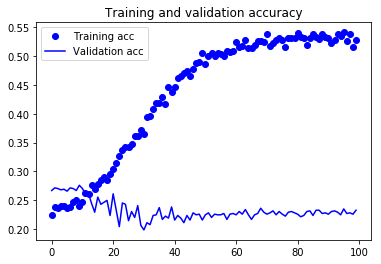

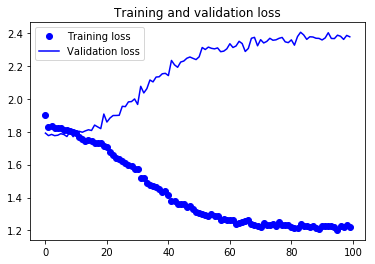

In [135]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Maximum validation accuracy in 100 epochs: 0.17715

In [138]:
model = models.Sequential()
model.add(layers.Convolution1D(256, 5, padding='same',kernel_regularizer=regularizers.l2(0.04),
                        input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Convolution1D(256, 5, padding='same',kernel_regularizer=regularizers.l2(0.04)))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Convolution1D(256, 5, padding='same',kernel_regularizer=regularizers.l2(0.04)))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.3))
model.add(layers.Convolution1D(256, 5, padding='same',kernel_regularizer=regularizers.l2(0.04)))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.3))
model.add(layers.TimeDistributed(layers.Dense(128, activation='relu')))
model.add(layers.Dropout(0.75))
model.add(layers.TimeDistributed(layers.Dense(NUM_GENRES, activation='softmax')))
time_distributed_merge_layer = layers.Lambda(
            function=lambda x: backend.mean(x, axis=1),
            output_shape=lambda shape: (shape[0],) + shape[2:],
            name='output_merged'
        )
model.add(time_distributed_merge_layer)

In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_85 (Conv1D)           (None, 108, 256)          164096    
_________________________________________________________________
batch_normalization_85 (Batc (None, 108, 256)          1024      
_________________________________________________________________
activation_85 (Activation)   (None, 108, 256)          0         
_________________________________________________________________
max_pooling1d_89 (MaxPooling (None, 54, 256)           0         
_________________________________________________________________
conv1d_86 (Conv1D)           (None, 54, 256)           327936    
_________________________________________________________________
batch_normalization_86 (Batc (None, 54, 256)           1024      
_________________________________________________________________
activation_86 (Activation)   (None, 54, 256)           0         
__________

In [139]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

Train on 2803 samples, validate on 701 samples
Epoch 1/50
2803/2803 [==============================] - 4s 2ms/step - loss: 38.1509 - acc: 0.1959 - val_loss: 36.5396 - val_acc: 0.1997
Epoch 2/50
2803/2803 [==============================] - 1s 217us/step - loss: 35.2194 - acc: 0.1923 - val_loss: 33.7271 - val_acc: 0.2040
Epoch 3/50
2803/2803 [==============================] - 1s 209us/step - loss: 32.4258 - acc: 0.2155 - val_loss: 30.9699 - val_acc: 0.2083
Epoch 4/50
2803/2803 [==============================] - 1s 228us/step - loss: 29.7313 - acc: 0.2248 - val_loss: 28.3813 - val_acc: 0.2040
Epoch 5/50
2803/2803 [==============================] - 1s 215us/step - loss: 27.1992 - acc: 0.2119 - val_loss: 25.9508 - val_acc: 0.2254
Epoch 6/50
2803/2803 [==============================] - 1s 220us/step - loss: 24.8253 - acc: 0.2369 - val_loss: 23.6752 - val_acc: 0.2340
Epoch 7/50
2803/2803 [==============================] - 1s 225us/step - loss: 22.6537 - acc: 0.2208 - val_loss: 21.5717 - val_a

range(0, 50)


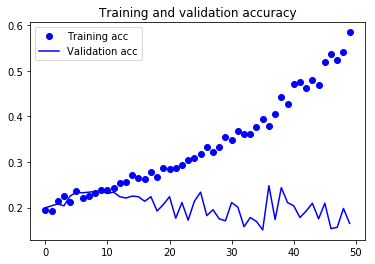

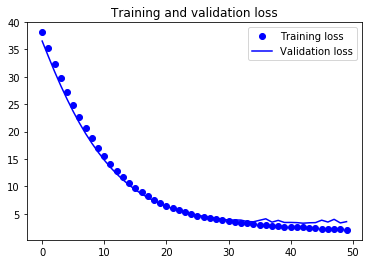

In [140]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [5]:
x = (x-np.amin(x))/(np.amax(x)-np.amin(x))
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2,
        random_state=42)

In [14]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', #padding='same',
                        input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(layers.MaxPooling2D((3, 3)))#, padding='same'))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))#, padding='same'))
model.add(layers.MaxPooling2D((3, 3)))#, padding='same'))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(768, (3, 3), activation='relu'))#, padding='same'))
model.add(layers.MaxPooling2D((3, 3)))#, padding='same'))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_GENRES, activation = 'softmax'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 106, 126, 128)     1280      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 35, 42, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 35, 42, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 33, 40, 384)       442752    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 13, 384)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 11, 13, 384)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 11, 768)        2654976   
__________

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 4130 samples, validate on 1033 samples
Epoch 1/100
4130/4130 [==============================] - 5s 1ms/step - loss: 2.2534 - acc: 0.1564 - val_loss: 2.1953 - val_acc: 0.1578
Epoch 2/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1926 - acc: 0.1685 - val_loss: 2.1933 - val_acc: 0.1578
Epoch 3/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1897 - acc: 0.1685 - val_loss: 2.1918 - val_acc: 0.1578
Epoch 4/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1874 - acc: 0.1685 - val_loss: 2.1907 - val_acc: 0.1578
Epoch 5/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1856 - acc: 0.1685 - val_loss: 2.1898 - val_acc: 0.1578
Epoch 6/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1842 - acc: 0.1685 - val_loss: 2.1893 - val_acc: 0.1578
Epoch 7/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1832 - acc: 0.1685 - val_loss: 2.1890 - val_acc: 0.1578
Epoch 8

Epoch 61/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1804 - acc: 0.1685 - val_loss: 2.1901 - val_acc: 0.1578
Epoch 62/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1804 - acc: 0.1685 - val_loss: 2.1901 - val_acc: 0.1578
Epoch 63/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1803 - acc: 0.1685 - val_loss: 2.1901 - val_acc: 0.1578
Epoch 64/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1804 - acc: 0.1685 - val_loss: 2.1902 - val_acc: 0.1578
Epoch 65/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1804 - acc: 0.1685 - val_loss: 2.1901 - val_acc: 0.1578
Epoch 66/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1803 - acc: 0.1685 - val_loss: 2.1902 - val_acc: 0.1578
Epoch 67/100
4130/4130 [==============================] - 4s 1ms/step - loss: 2.1804 - acc: 0.1685 - val_loss: 2.1901 - val_acc: 0.1578
Epoch 68/100
4130/4130 [========================

range(0, 100)


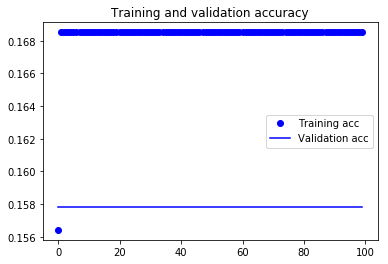

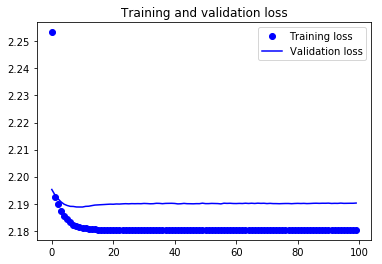

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()